# Bayesian statistics

- work in progress

This notebook builds on examples in Hoff (*see* References).

In [1]:
# Libraries
library(tidyverse)
library(readxl)

library(LearnBayes)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'LearnBayes' was built under R version 4.5.2"


In [2]:
# Helpers
excol_to_index <- function(excel_col) {
    # Input an Excel column code and return the index
    excel_col <- trimws(toupper(as.character(excel_col)))

    if (is.na(excel_col) || (nchar(excel_col) == 0)) {
        warning("Input must be a non-empty character string.") 
        return(NA) 
    }
    
    characters <- utf8ToInt(excel_col) - utf8ToInt("A") + 1

    if (any(characters < 1 | characters > 26)) {
        warning("Input must contain only letters.")
        return(NA)
    }

    index <- 0
    for (i in seq_along(characters)) { index <- index * 26 + characters[i] }
    
    return(index)
}

# Hoff 1.2.1

## Some data

In [3]:
# Data
root_folder <- r"(D:\data\electoral_commission_public_attitudes)"
table <- suppressMessages(
    header_df <- read_excel(
        file.path(root_folder, r"(Electoral Commission Winter Tracker 2018-2025 Historical Data v3.xlsx)"),
        sheet = "Counts", 
        col_names = FALSE, 
        col_types = NULL, 
        skip = 4, 
        n_max = 3
    )
)

In [4]:
# Q9D2. How did you register to vote (2022)?
table <- suppressMessages(
    q9d2_df <- read_excel(
        file.path(root_folder, r"(Electoral Commission Winter Tracker 2018-2025 Historical Data v3.xlsx)"),
        sheet = "Counts", 
        col_names = TRUE, 
        col_types = NULL, 
        skip = 1479, 
        n_max = 9
    )
)

q9d2_df <- q9d2_df |>
    janitor::clean_names() |>
    select(1, 7) |>
    rename(answer = 1) |>
    rename(yr_2022 = x7) |>
    mutate(yr_2022 = as.integer(yr_2022)) |>
    filter(!is.na(yr_2022)) |>
    mutate(answer = case_match(
            answer,
            "Online" ~ "online",
            "Using a paper form" ~ "paper",
            .default = NA_character_
        )
    ) |>
    filter(answer %in% c("online", "paper"))

q9d2_df

answer,yr_2022
<chr>,<int>
online,50
paper,7


In [5]:
table <- suppressMessages(
    q23d2_df <- read_excel(
        file.path(root_folder, r"(Electoral Commission Winter Tracker 2018-2025 Historical Data v3.xlsx)"),
        sheet = "Counts", 
        col_names = TRUE, 
        col_types = NULL, 
        skip = 3517, 
        n_max = 9
    )
)

# Q23D. A deepfake video is a media in which a person in an existing video is replaced with someone else's likeness.Have you seen a deepfake video in the last year?
q23d2_df <- q23d2_df |>
    janitor::clean_names() |>
    select(1, 7, 8) |>
    rename(answer = 1) |>
    rename(yr_2022 = 2) |>
    rename(yr_2023 = 3) |>
    mutate(
        answer = str_to_lower(answer),
        yr_2022 = as.integer(yr_2022),
        yr_2023 = as.integer(yr_2023)
    ) |>
    filter(answer %in% c("yes", "no"))

q23d2_df

answer,yr_2022,yr_2023
<chr>,<int>,<int>
yes,1054,856
no,2466,2062


## Binomial likelihood

If $y_i | \theta \sim \text{binomial}(k;n)$, then,

$$
f(y_i \mid \theta) = \text{binom}(y_1,..., y_n;n,\theta) = \binom{n}{k} \prod_{i=1}^n \theta^{y_i} (1-\theta)^{y_i-k}
$$

$$
f(y_i \mid \theta) = \text{binom}(k;n,\theta) = \binom{n}{k} \theta^k (1-\theta)^{n-k}
$$

Where $k=\sum_{i=1}^n 1_{\{y_i = 1\}}$ denotes the count of successes, $n$ the number of Bernoulli trials and $\theta$ the probability of success with $\mathbb{E}\left[y_i\right]=\theta$ and $\text{Var}(y_i)\theta(1-\theta)$. We take $\theta$ to be the proportion or *shape* parameter.

Native binomial function: https://www.rdocumentation.org/packages/stats/versions/3.3/topics/Binomial

In [6]:
binomial_pmf <- function(k, n, theta=0.5) {
    # Binomial PMF
    p <- choose(n, k) * (theta^k) * (1 - theta)^(n - k)
    output <- list(
        p = p,
        mean = p,
        variance = p * (1 - p)
    )
    return(output)
}

In [7]:
near(
    dbinom(3, 20, 0.5),
    binomial_pmf(3, 20, 0.5)[["p"]]
)

[1] TRUE

$$
f(y \mid \theta) = \binom{n}{k} \theta^k (1-\theta)^{n-k}, \quad
\text{for}\,n=20,\theta\in\{0.05, 0.25, 0.5, 0.75, 0.95\}
$$

In [8]:
# Binomial distributions for a set of parameters
n <- 20
k_vals <- 0:n
theta <- c(0.05, 0.25, 0.5, 0.75, 0.95)

fns <- tibble(k = k_vals)

for (i in seq_along(theta)) {
    fn <- sapply(k_vals, function(k) binomial_pmf(k, n, theta[i])[["p"]])
    col_name <- paste0("theta_", i)
    fns[[col_name]] <- fn
}

fns_long <- fns |>
    pivot_longer(
        cols = -k,
        names_to = "variable",
        values_to = "value"
    )

fns_long |> head()

k,variable,value
<int>,<chr>,<dbl>
0,theta_1,3.584859e-01
0,theta_2,3.171212e-03
0,theta_3,9.536743e-07
0,theta_4,9.094947e-13
0,theta_5,9.536743e-27
1,theta_1,3.773536e-01


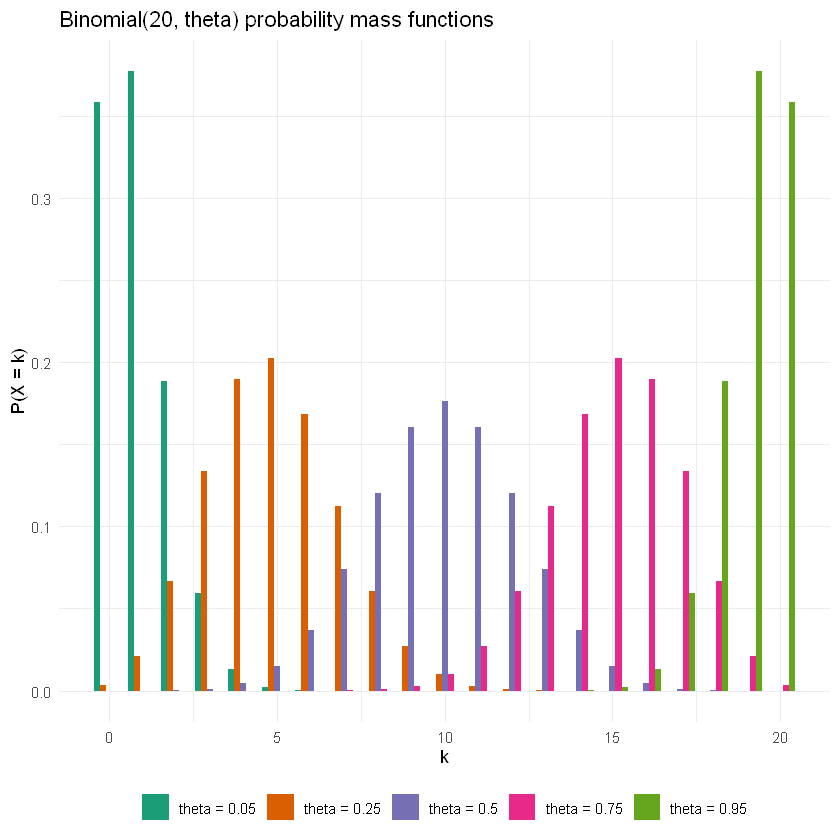

In [9]:
theta_vec <- paste0("theta_", seq(length(theta)))
theta_lab <- paste0("theta = ", theta)
colours <- RColorBrewer::brewer.pal(length(theta_vec), "Dark2")

ggplot(fns_long, aes(x = k, y = value, fill = variable)) +
  geom_col(position = "dodge") +
  theme_minimal() +
  theme(legend.position = "bottom") +
  labs(
    x = "k",
    y = "P(X = k)",
    fill = NULL, # "theta values",
    title = "Binomial(20, theta) probability mass functions"
  ) +
  scale_fill_manual(
    values = setNames(colours, theta_vec),
    labels = setNames(theta_lab, theta_vec)
  )

## Gamma function

$$
\Gamma (x) = (x-1)! = \Gamma (z)=\int_{0}^{\infty} t^{z-1}e^{-t} \, dt, \quad
\text{for } n \in \mathbb{R}_+, z=a+bi \text{ s.t. } a \in \mathbb{R}_+
$$

## Beta prior

If $\theta \sim \text{beta}(\alpha,\beta)$, then,

$$
g(\theta; \alpha,\beta)=\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}, \quad
B(\alpha,\beta) = \int_0^1 t^{\alpha-1}(1-t)^{\beta-1}\,dt = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

With $\mathbb{E}\left[\theta\right]=\frac{\alpha}{\alpha+\beta}$ and $\text{Var}(\theta)=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$. We take $\alpha,\beta$ to be *shape* parameters, $B(\alpha,\beta)$ the *constant* and $\theta^{\alpha-1}(1-\theta)^{\beta-1}$ the *kernel*.

Native beta function: https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Beta

In [10]:
beta_pdf <- function(theta, alpha, beta=0.5) {
    # Beta PDF
    constant <- 1 / beta(alpha, beta)
    kernel <- theta^(alpha - 1) * (1 - theta)^(beta - 1)
    output <- list(
        p = constant * kernel,
        kernel = kernel,
        mean = alpha / (alpha + beta),
        variance = (alpha * beta) / ((alpha + beta)^2 * (alpha + beta  + 1))
    )
    return(output)
}

In [11]:
near(
    dbeta(0.5, 0.5, 0.5),
    beta_pdf(0.5, 0.5, 0.5)[["p"]]
)

[1] TRUE

## Beta-binomial posterior

The cojugates posterior is then $\theta \mid \mathbf{y} \sim \text{beta}(\alpha+k,\beta+n-k)$,

$$
g(\theta \mid y_1,...,y_n) = \frac{f(\mathbf{y} \mid \theta)g(\theta)}{f(\mathbf{y})} = \frac{f(\mathbf{y} \mid \theta)g(\theta)}{\int_0^1 f(\mathbf{y} \mid \theta)g(\theta) \,d\theta} \propto f(\mathbf{y} \mid \theta)g(\theta)
$$

Then,

$$
f(\mathbf{y} \mid \theta)g(\theta) = \theta^k(1-\theta)^{n-k}\theta^{\alpha-1}(1-\theta)^{\beta-1} = \theta^{k+\alpha-1}(1-\theta)^{n-k+\beta-1}
$$

### $\alpha$ and $\beta$

#### Prior mean $\mu$ and concentration $\kappa$

For $\theta\sim\mathrm{Beta}(\alpha,\beta)$,

$$
\mathbb{E}[\theta]=\frac{\alpha}{\alpha+\beta}=m,\quad
\alpha+\beta=\kappa
$$

Solve,

$$
\alpha = m\kappa,\quad
\beta=(1-m)\kappa
$$

Where $m$ is an assumed mean and $\kappa$ an assumed weight.

#### Match mean $\mu$ and variance $v$

For beta,

$$
\mathrm{Var}(\theta)=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}=v
$$

Then,

$$
\alpha=m\kappa,
\quad \beta=(1-m)\kappa,\quad
\kappa=\frac{m(1-m)}{v}-1
$$

#### Assume quantiles

$$
P(\theta \le 0.2)=0.1, \quad P(\theta \le 0.6)=0.9
$$

Then,

```R
library(LearnBayes)
# 10th percentile at 0.2 and 90th at 0.6
beta.select(list(p=0.1, x=0.2), list(p=0.9, x=0.6))
```

Alternatively use empirical Bayes.

In [12]:
theta_len <- 1e4L
theta_ran <- c(0.0, 0.5) # Assumed range
theta_vec <- seq(theta_ran[1], theta_ran[2], length.out = theta_len) # Vector of possible parameters

n <- 20 # Sample
k <- 0 # Number of observed infected

# Assume a flat beta(1,1) or Jeffreys beta(1/2,1/2) prior
alpha <- 2
beta <- 20

densities_df <- tibble(
        theta = theta_vec,
        prior = sapply(
            theta_vec,
            function(x) { beta_pdf(x, alpha, beta)[["p"]] }
        ),
        posterior = sapply(
            theta_vec,
            function(x) { beta_pdf(x, alpha + k, beta + n - k)[["p"]] }
        )
    )

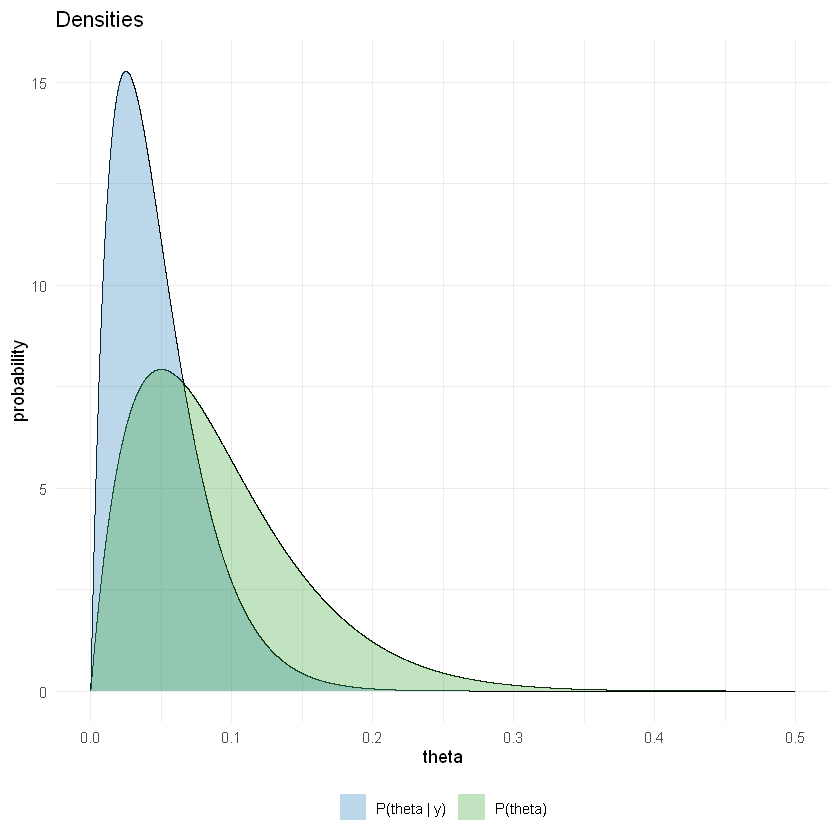

In [13]:
densities_fig <- densities_df |>
    pivot_longer(
        cols = -theta,
        names_to = "var",
        values_to = "val"
    )

ggplot(densities_fig, aes(x = theta, y = val, fill = var)) + 
    geom_line() +  
    geom_area(position = "identity", alpha = 0.3, color = NA) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    labs(
        x = "theta",
        y = "probability",
        fill = NULL,
        title = "Densities"
    ) +
    scale_fill_manual(
        values = c(posterior = "#1f78b4", prior = "#33a02c"),
        labels = c(posterior = "P(theta | y)", prior = "P(theta)")
    )

## Contour maps

Invert the posterior mean formula.

$$
\mathbb{E}\left[\theta\mid Y=y\right]=\frac{n}{\kappa+n}\bar{y}+\frac{\kappa}{\kappa+n}\theta_0 \Rightarrow \theta_0=\frac{\kappa+n}{\kappa}\mathbb{E}\left[\theta\mid Y=y\right]-\frac{n}{\kappa}\bar{y}
$$

Where $\mathbb{E}\left[\theta\mid Y=y\right]$ is the posterior mean and $\theta_0$ the prior mean required to obtain the given posterior mean.

In [14]:
weight_vec <- seq(0, 25, length.out = theta_len)
posterior_theta <- seq(0.05, 0.25, 0.05)

y_bar <- k / n

prior_theta <- function(posterior_theta, y_bar, n, w) {
    t0 <- (posterior_theta * (w + n) / w) - (n * y_bar / w)
    return(t0)
}

prior_theta_mat <- matrix(0, nrow=theta_len, length(posterior_theta))

for (i in seq_along(posterior_theta)) {
    t_vec <- sapply(
        weight_vec,
        function(x) {
            prior_theta(posterior_theta[i], y_bar, n, x)
        }
    )
    prior_theta_mat[,i] <- t_vec
}

prior_theta_df <- as_tibble(prior_theta_mat)

prior_theta_df <- prior_theta_df |>
    rename_with(
        .cols = everything(),
        .fn = ~ str_replace(.x, ".*(?=\\d)", "prior_theta_")
    ) |>
    mutate(kappa = weight_vec) |>
    relocate(kappa, .before = 1)

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`."


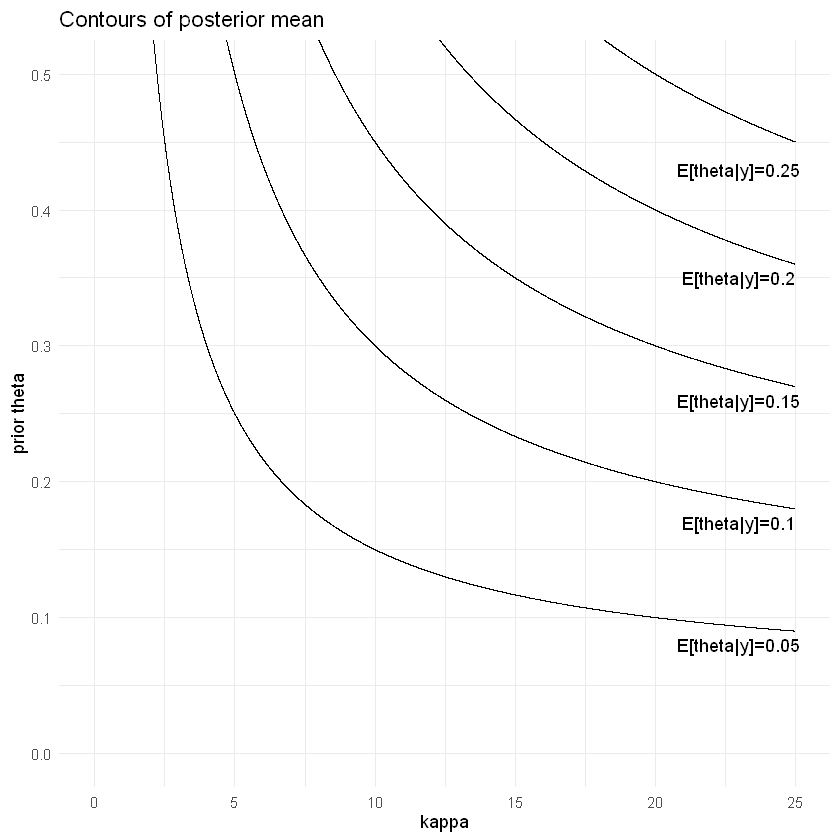

In [15]:
prior_theta_fig <- prior_theta_df |>
    pivot_longer(
        cols = starts_with("prior"),
        names_to = "var",
        values_to = "val"
    ) |>
    filter(!is.na(val))

prior_cols <- prior_theta_df|> select(-kappa) |> colnames()
colours <- RColorBrewer::brewer.pal(length(prior_cols), "Dark2")

ggplot(prior_theta_fig, aes(x = kappa, y = val, fill = var)) + 
    geom_line() +
    coord_cartesian(xlim = c(0, 25), ylim = c(0, 0.5)) +
    annotate("text", x=23, y=0.08, label= paste0("E[theta|y]=", posterior_theta[1])) +
    annotate("text", x=23, y=0.17, label= paste0("E[theta|y]=", posterior_theta[2])) +
    annotate("text", x=23, y=0.26, label= paste0("E[theta|y]=", posterior_theta[3])) +
    annotate("text", x=23, y=0.35, label= paste0("E[theta|y]=", posterior_theta[4])) +
    annotate("text", x=23, y=0.43, label= paste0("E[theta|y]=", posterior_theta[5])) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    labs(
        x = "kappa",
        y = "prior theta",
        color = NULL,
        title = "Contours of posterior mean"
    )

## A look at some real data



## Reference material

Hoff, P.D. (2009) *A First Course in Bayesian Statistical Methods*. Springer.

Marin, J.M. and Robert, C. (2014) *Bayesian Essentials with R*, 2nd edn. Springer.

Matsuura, K. (2022) *Bayesian Statistical Modeling with Stan, R, and Python*. Springer.

NC State University (n.d.) 'Jeffrey's prior derivations'. https://st740.wordpress.ncsu.edu/files/2023/09/JP_derivations.pdf